In [1]:
# Basic python libraries.
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get rid of warnings!
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries.
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout,GlobalAveragePooling2D,MaxPooling2D,Flatten,Conv2D,BatchNormalization,Activation
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from tensorflow.keras.utils import plot_model
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import itertools

print('Above libraries have been imported.')

2024-12-11 21:07:18.948780: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 21:07:18.948905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 21:07:19.072423: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Above libraries have been imported.


In [3]:
folder_path = "/kaggle/input/fer2013"
train_dir = '/kaggle/input/fer2013/train'
val_dir = '/kaggle/input/fer2013/test'

In [5]:
# Define the default image size.
img_size = 48

# Define the seven emotions provided in dataset.
emotion_list = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Plot the images with each distinct emotions.
plt.figure(figsize=(18,22))
i = 1
for expression in emotion_list:
    img = load_img((train_dir + '/' + expression +'/'+ os.listdir(train_dir + '/' + expression)[59]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# Rescale the data.
'''
Before we proceed we need to rescale our data by multiplying it to 1/255.
This is done so we get target values between 0 and 1.
'''
# Rescale train data.
datagen_train = ImageDataGenerator(rescale = 1./255,
                                  )

# Rescale validation data.
datagen_val = ImageDataGenerator(rescale = 1./255,
                                 )

print('Above data generator functions have been created.')

# Perform data augmentation.
'''
Data augmentation is a technique to artificially create new training data from existing training data. 
It helps us to increase the size of the dataset and introduce variability in the dataset.
'''
# Define the default image size.
img_size = 48

# Define batch size.
batch_size = 64

# Training data.
train_set = datagen_train.flow_from_directory(directory=train_dir,
                                              target_size=(img_size,img_size),
                                              batch_size = batch_size,
                                              color_mode = 'grayscale',
                                              class_mode = "categorical",
                                              shuffle=True
                                              )

# Validation data.
val_set = datagen_train.flow_from_directory(directory=val_dir,
                                              target_size=(img_size,img_size),
                                              batch_size = batch_size,
                                              color_mode = 'grayscale',
                                              class_mode = "categorical",
                                              shuffle=False
                                              )

print('Train and Validation sets have been created.')

Above data generator functions have been created.
Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Train and Validation sets have been created.


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Add, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.regularizers import l2

# Input layer
input_layer = Input(shape=(48, 48, 1))

# First layer
x = Conv2D(32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.01))(input_layer)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01))(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

# Second layer
x = Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(0.01))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01))(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

# Third layer with Residual Connection
shortcut = x  # Save the shortcut connection
x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.01))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.01))(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # Reduces spatial dimensions
x = Dropout(0.3)(x)

# Adjust the shortcut to match x's shape
shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='same', kernel_regularizer=l2(0.01))(shortcut)

# Add the residual connection
x = Add()([x, shortcut])


# Fourth layer
x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.01))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.01))(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

# Global Average Pooling instead of Flatten
x = GlobalAveragePooling2D()(x)

# Fully connected layers
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Output layer
output_layer = Dense(7, activation='softmax')(x)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print('Functional API CNN model with advanced complexity has been created.')

# Ensure GPU usage (automatically happens if GPU is enabled in Colab)
with tf.device('/GPU:0'):
    # Uncomment the training part and use your training and validation datasets
    history = model.fit(train_set,
                        steps_per_epoch=train_set.n // train_set.batch_size,
                        validation_data=val_set,
                        validation_steps=val_set.n // val_set.batch_size,
                        epochs=50)

    print('Your model is ready to be trained on GPU!!')


Functional API CNN model with advanced complexity has been created.
Epoch 1/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 213s 429ms/step - accuracy: 0.1908 - loss: 20.2236 - val_accuracy: 0.2475 - val_loss: 3.4476
Epoch 2/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.1562 - loss: 3.6684

2024-12-11 21:14:10.158127: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.6297, expected 1.1253
2024-12-11 21:14:10.158195: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.33636, expected 1.83196
2024-12-11 21:14:10.158210: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.37284, expected 1.86844
2024-12-11 21:14:10.158220: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.90532, expected 2.40092
2024-12-11 21:14:10.158234: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.27154, expected 1.76715
2024-12-11 21:14:10.158249: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.18271, expected 1.67831
2024-12-11 21:14:10.158260: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.44143, expected 1.93703
2024-12-11 21:14:10.158271: E external/local_xla/xla/serv

448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1562 - loss: 3.6684 - val_accuracy: 0.0000e+00 - val_loss: 3.5253
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 49s 107ms/step - accuracy: 0.2169 - loss: 2.9910 - val_accuracy: 0.1723 - val_loss: 2.2513
Epoch 4/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 38us/step - accuracy: 0.2500 - loss: 2.1315 - val_accuracy: 0.0000e+00 - val_loss: 2.6124
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 48s 106ms/step - accuracy: 0.2305 - loss: 2.2171 - val_accuracy: 0.2533 - val_loss: 2.1059
Epoch 6/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 38us/step - accuracy: 0.3594 - loss: 2.0005 - val_accuracy: 0.0000e+00 - val_loss: 3.5182
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 48s 105ms/step - accuracy: 0.2848 - loss: 2.0895 - val_accuracy: 0.2720 - val_loss: 2.3244
Epoch 8/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 39us/step - accuracy: 0.3438 - loss: 1.9634 - val_accuracy: 0.0000e+00 - val_loss: 4.0474
Epoch 9/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 49s 107ms/step - accuracy: 0.3697 - loss: 1.949

In [7]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 48,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 48, 48,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 48, 48,    │     18,496 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 48, 48,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 48,    │        256 │ leaky_re_lu_1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 24,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 24,    │    204,928 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 24, 24,    │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │    147,584 │ leaky_re_lu_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 24, 24,    │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ leaky_re_lu_3[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 12, 12,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 12, 12,    │    590,336 │ dropout_1[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 12, 12,    │          0 │ conv2d_4[0][0]  

 Total params: 5,831,559 (22.25 MB)

 Trainable params: 5,826,567 (22.23 MB)

 Non-trainable params: 4,992 (19.50 KB)

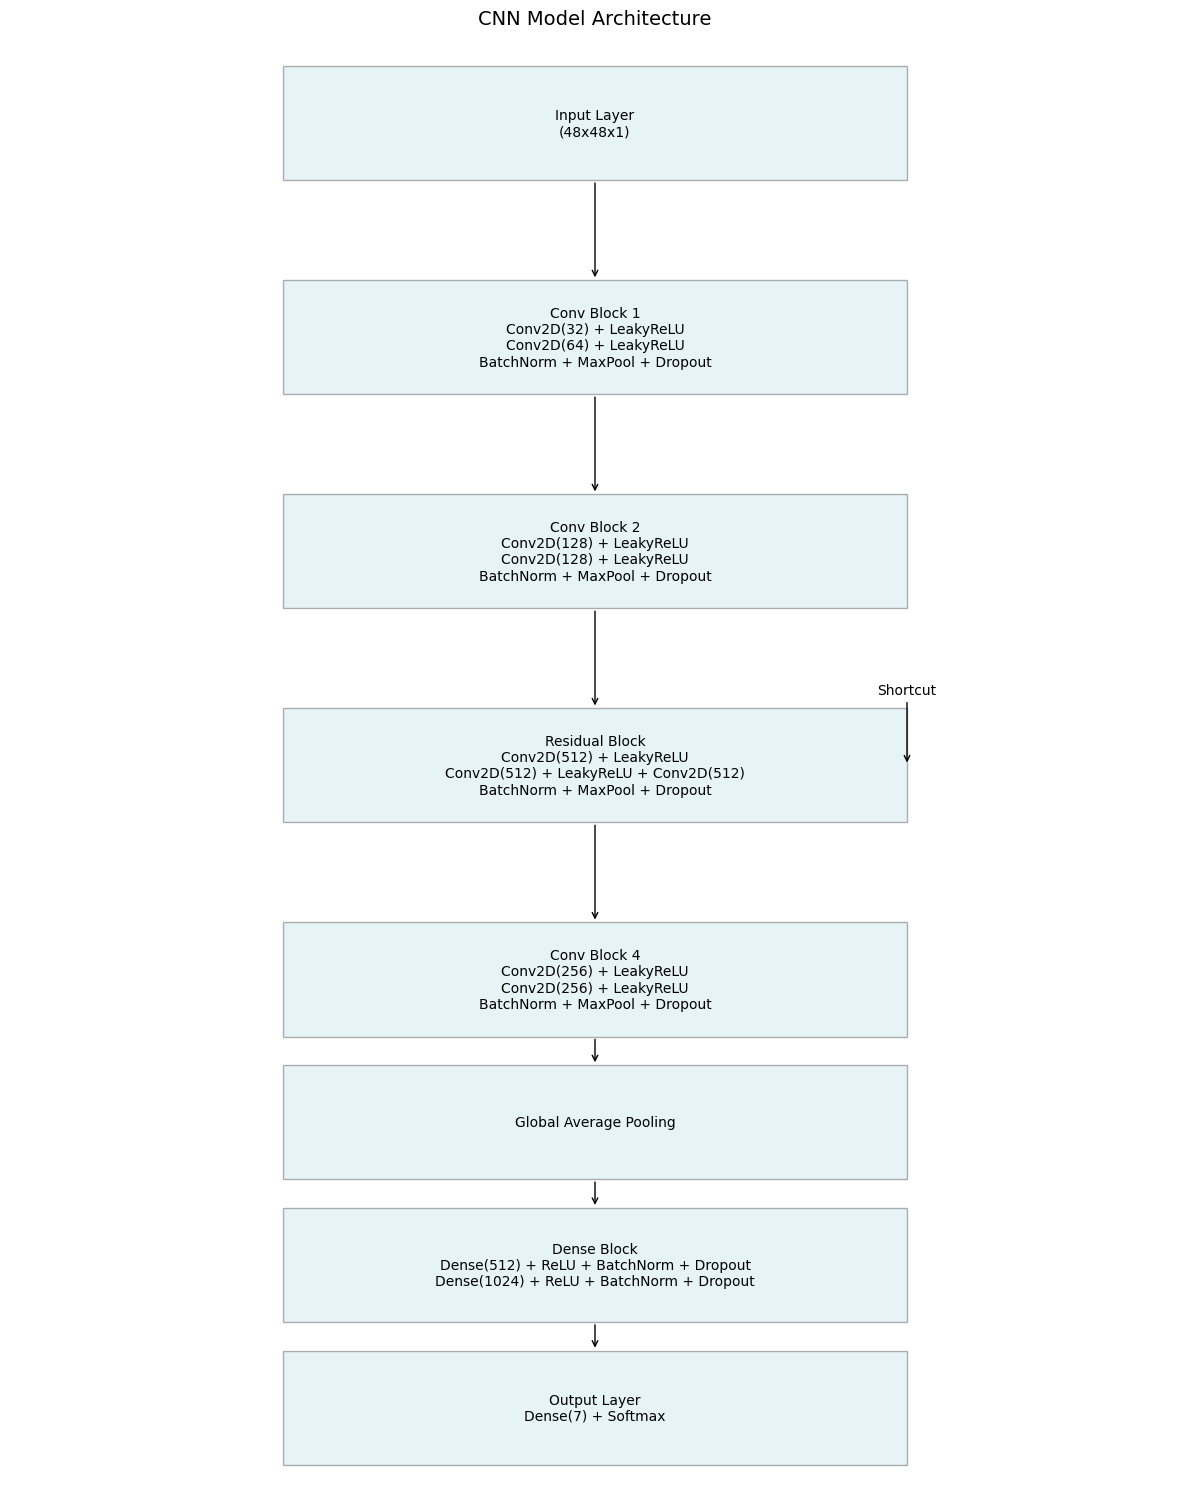

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 15))

# Define blocks with more detailed labels
blocks = [
    ("Input Layer\n(48x48x1)", (0.5, 9)),
    ("Conv Block 1\nConv2D(32) + LeakyReLU\nConv2D(64) + LeakyReLU\nBatchNorm + MaxPool + Dropout", (0.5, 7.5)),
    ("Conv Block 2\nConv2D(128) + LeakyReLU\nConv2D(128) + LeakyReLU\nBatchNorm + MaxPool + Dropout", (0.5, 6)),
    ("Residual Block\nConv2D(512) + LeakyReLU\nConv2D(512) + LeakyReLU + Conv2D(512)\nBatchNorm + MaxPool + Dropout", (0.5, 4.5)),
    ("Conv Block 4\nConv2D(256) + LeakyReLU\nConv2D(256) + LeakyReLU\nBatchNorm + MaxPool + Dropout", (0.5, 3)),
    ("Global Average Pooling", (0.5, 2)),
    ("Dense Block\nDense(512) + ReLU + BatchNorm + Dropout\nDense(1024) + ReLU + BatchNorm + Dropout", (0.5, 1)),
    ("Output Layer\nDense(7) + Softmax", (0.5, 0))
]

# Add blocks with more padding for text
for label, (x, y) in blocks:
    ax.add_patch(Rectangle((x - 0.8, y - 0.4), 1.6, 0.8, 
                          edgecolor='black', 
                          facecolor='lightblue',
                          alpha=0.3))
    ax.text(x, y, label, ha='center', va='center', fontsize=10)

# Add residual connection
ax.annotate('Shortcut', 
           xy=(1.3, 4.5), xytext=(1.3, 5),
           arrowprops=dict(arrowstyle='->'),
           ha='center')

# Add arrows between blocks
for i in range(len(blocks) - 1):
    x1, y1 = blocks[i][1]
    x2, y2 = blocks[i + 1][1]
    ax.annotate('', xy=(x2, y2 + 0.4), xytext=(x1, y1 - 0.4),
                arrowprops=dict(facecolor='black', arrowstyle='->'))

# Set axis limits and remove axes
ax.set_xlim(-1, 2)
ax.set_ylim(-0.5, 9.5)
ax.axis('off')

plt.title("CNN Model Architecture", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig("model_architecture")
plt.show()

In [9]:
history = model.fit( train_set,
                              steps_per_epoch=train_set.n//train_set.batch_size,
                              validation_data = val_set,
                              validation_steps=val_set.n//val_set.batch_size,
                              epochs = 50)

print('Your model has been trained!!')

Epoch 1/50


2024-12-11 21:08:26.998542: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.16473, expected 0.928603
2024-12-11 21:08:26.998618: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 1.1794, expected 0.943274
2024-12-11 21:08:26.998632: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 0.892153, expected 0.656024
2024-12-11 21:08:26.998645: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 1.163, expected 0.926874
2024-12-11 21:08:26.998659: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 1.33797, expected 1.10184
2024-12-11 21:08:26.998674: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 1.18042, expected 0.944295
2024-12-11 21:08:26.998687: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19: 1.28869, expected 1.05256
2024-12-11 21:08:26.998698: E external/local_xla

  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:27:24 28s/step - accuracy: 0.1719 - loss: 31.0357

I0000 00:00:1733951321.030565     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 42/448 ━━━━━━━━━━━━━━━━━━━━ 2:15 334ms/step - accuracy: 0.1708 - loss: 30.5690

2024-12-11 21:09:00.185568: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2313: 1.13338, expected 0.917281
2024-12-11 21:09:00.185641: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2314: 0.740248, expected 0.524152
2024-12-11 21:09:00.185657: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2324: 1.00032, expected 0.784221
2024-12-11 21:09:00.185670: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2329: 1.13723, expected 0.921129
2024-12-11 21:09:00.185684: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2334: 0.840364, expected 0.624268
2024-12-11 21:09:00.185700: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2335: 0.72674, expected 0.510644
2024-12-11 21:09:00.185726: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2337: 1.04913, expected 0.833037
2024-12-11 21:09:00.18573

KeyboardInterrupt: 

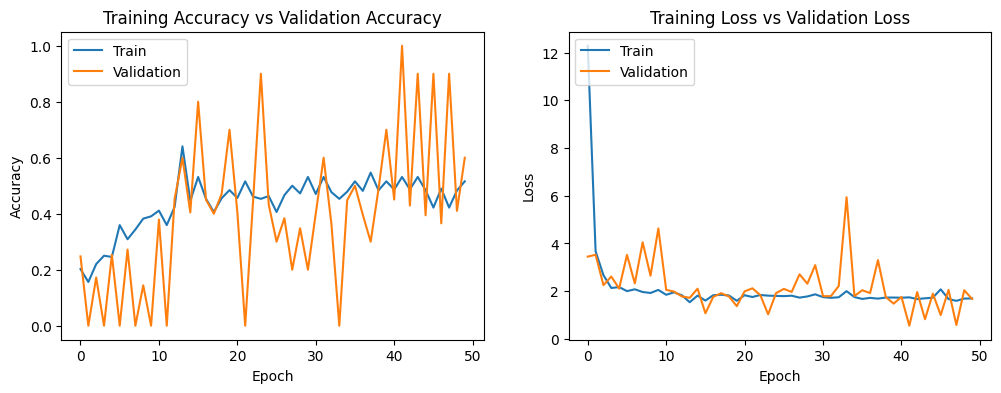

In [11]:

# Create plots for accuracy and loss.
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
model.summary()

113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step


<Figure size 640x480 with 0 Axes>

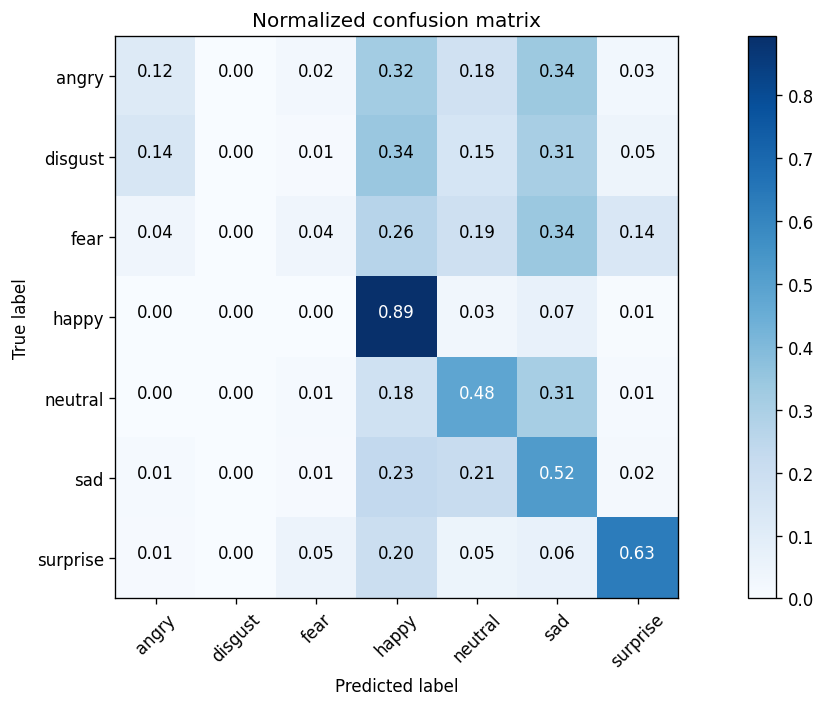

In [12]:
# Create confusion matrix of our predictions

# compute predictions
predictions = model.predict(val_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = val_set.classes
class_names = val_set.class_indices.keys()

# Create function to plot confussion matrix.
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,6), dpi=120)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')# **Live Class Monitoring System(Face Emotion Recognition)**
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


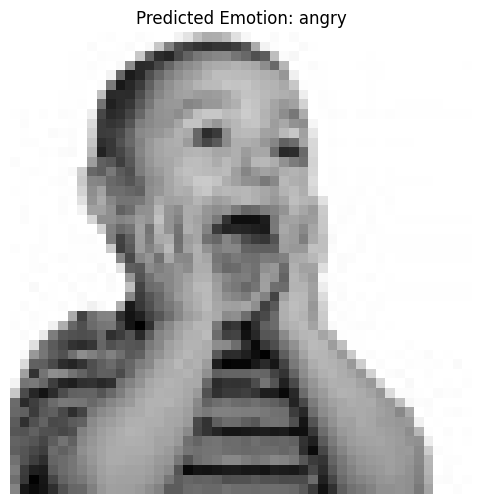

In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Select a random image from the dataset
emotion = random.choice(emotion_list)
image_filename = random.choice(os.listdir(train_dir + '/' + emotion))
img_path = train_dir + '/' + emotion + '/' + image_filename

# Load the image
img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
img_array = image.img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Rescale image

# Predict the emotion
pred = model.predict(img_array)
predicted_emotion = emotion_list[np.argmax(pred)]  # Get the emotion with the highest probability

# Plot the image and predicted emotion
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.title(f'Predicted Emotion: {predicted_emotion}')
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


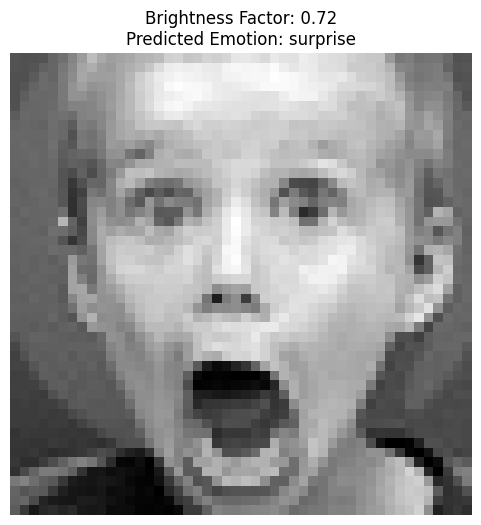

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


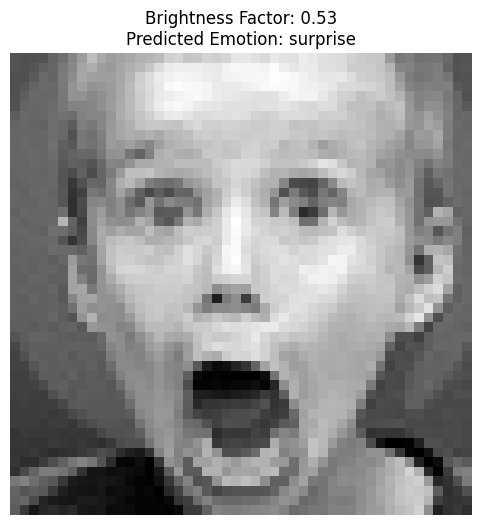

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


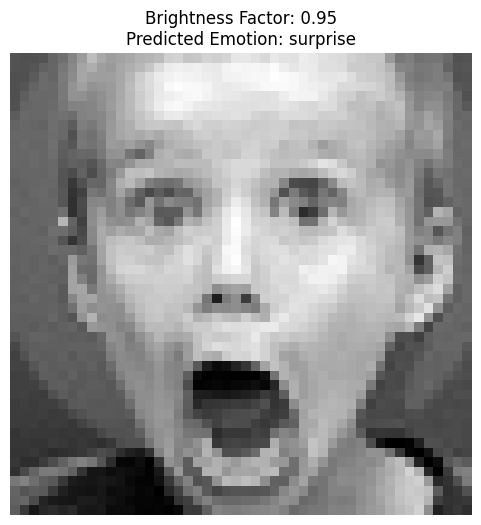

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


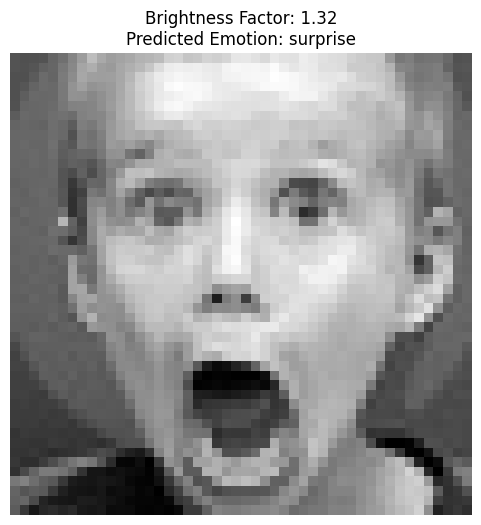

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


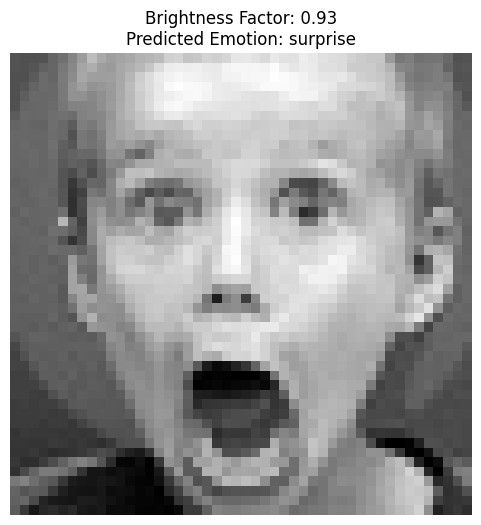

In [20]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to adjust brightness
def adjust_brightness(img, factor):
    img = np.array(img)
    img = img * factor
    img = np.clip(img, 0, 255)  # Ensure pixel values stay within valid range
    return img

# Select a random image from the dataset
emotion = random.choice(emotion_list)
image_filename = random.choice(os.listdir(train_dir + '/' + emotion))
img_path = train_dir + '/' + emotion + '/' + image_filename

# Load the image
img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
img_array = image.img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Rescale image

# Loop to adjust brightness and predict
num_iterations = 5  # Number of times to adjust brightness and predict
for i in range(num_iterations):
    # Adjust brightness randomly between 0.5 and 1.5
    brightness_factor = random.uniform(0.5, 1.5)
    bright_img_array = adjust_brightness(img_array[0], brightness_factor)
    
    # Rescale back to range [0, 1]
    bright_img_array = np.expand_dims(bright_img_array, axis=0)  # Add batch dimension
    bright_img_array = bright_img_array / 255.0
    
    # Predict the emotion
    pred = model.predict(bright_img_array)
    predicted_emotion = emotion_list[np.argmax(pred)]  # Get the emotion with the highest probability
    
    # Plot the image with predicted emotion and brightness factor
    plt.figure(figsize=(6, 6))
    plt.imshow(bright_img_array[0], cmap='gray')
    plt.title(f'Brightness Factor: {brightness_factor:.2f}\nPredicted Emotion: {predicted_emotion}')
    plt.axis('off')
    plt.show()
